# Usage

This notebook provides the steps to build a network starting from a list of genes, and using the default functionalities of NeKo.

In [1]:
%%time
from neko.core.network import Network
from neko._visual.visualize_network import NetworkVisualizer
from neko.inputs import Universe, signor
import omnipath as op

(CORNETO) Sep 04 10:01:51 AM - WARNING : No backend found. You can install one of the supported backend by `pip install cvxpy` or `pip install picos`.
CPU times: user 4.86 s, sys: 1.2 s, total: 6.06 s
Wall time: 5.76 s


## 1. Define the list of genes of interest

In [2]:
genes = ["MAP2K1", "PIK3CA", "CTNNB1", "MAP3K7", "MAPK14", "GSK3B", "AKT1"]
output_nodes = ["MYC", "CCND1", "TCF7L2", "FOXO3", "CASP8", "CASP9"]

## 2. Create a network using as input the gene set. 

<div class="alert alert-info">

**Note**
    
NB! If no resource is specified, the default used resource by the package is `omnipath.all_interactions()`. To add new resources, please see the [Add resources](https://omniflow-project.readthedocs.io/en/latest/notebooks/add_resources.html#) tutorial. 

</div>  


### 2A. Import genes as network nodes

In [6]:
import pandas as pd

file_path = "./usecase_neko_ags/signor_db.tsv" # insert here the path to the signor.tsv file

df = pd.read_csv(file_path, sep='\t')

df_filtered = df.loc[(df['TYPEA'] == 'protein') & (df['TYPEB'] == 'protein')]

# export df
df_filtered.to_csv("./usecase_neko_ags/Signor_filtered.tsv", sep='\t')

In [7]:
resources = Universe()
resources = signor("./usecase_neko_ags/Signor_filtered.tsv")  # here you put the signor file path
resources.build()

In [9]:
resources.interactions

,source,target,is_directed,is_stimulation,is_inhibition,form_complex,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources
0,A0A0B4J2F0,P18848,True,False,True,False,False,False,False,miannu,31653868,SIGNOR-261041
1,A0A0B4J2F0,P35638,True,False,True,False,False,False,False,miannu,31653868,SIGNOR-261043
2,A0PJZ3,P46531,True,True,False,False,False,False,False,gcesareni,22117070,SIGNOR-177714
3,A0PJZ3,Q04721,True,True,False,False,False,False,False,gcesareni,22117070,SIGNOR-177717
4,A1A4S6,P61586,True,False,True,False,False,False,False,Luana,32203420,SIGNOR-260465
...,...,...,...,...,...,...,...,...,...,...,...,...
16353,Q9Y6X9,Q9H0A0,True,True,False,False,False,False,False,miannu,31616951,SIGNOR-273716
16354,Q9Y6Y1,P01160,True,True,False,False,False,False,False,Luana,21857646,SIGNOR-261570
16355,Q9Y6Y8,Q15436,True,True,False,False,False,False,False,lperfetto,10400679,SIGNOR-265307
16356,Q9Y6Y8,Q15437,True,True,False,False,False,False,False,lperfetto,10400679,SIGNOR-265306


In [10]:
new_net = Network(genes, resources = resources.interactions)


In [11]:
#Print node dataframe
new_net.nodes

,Genesymbol,Uniprot,Type
0,MAP2K1,Q02750,NaN
1,PIK3CA,P42336,NaN
2,CTNNB1,P35222,NaN
3,MAP3K7,O43318,NaN
4,MAPK14,Q16539,NaN
5,GSK3B,P49841,NaN
6,AKT1,P31749,NaN


### 2B. Explore if the nodes are connected without introducing new intermidiate nodes

In [12]:
%%time
#new_net1.connect_nodes(only_signed=True, consensus_only=True)
new_net.connect_as_atopo(max_len=1, strategy="radial",outputs=output_nodes)

CPU times: user 4.35 s, sys: 0 ns, total: 4.35 s
Wall time: 4.36 s


In [14]:
df = new_net.convert_edgelist_into_genesymbol()

In [16]:
df

,source,target,Type,Effect,References
0,MAP2K1,IRS1,None,inhibition,11160134
1,MAP2K1,MAPK3,None,stimulation,9677429; 12270934; 11730323
2,MAP2K1,MAPK1,None,stimulation,12270934; 11730323; 11971971
3,MAP2K1,GSK3B,None,stimulation,15020233
4,MAP2K1,MAPK14,None,inhibition,18481201
...,...,...,...,...,...
266,MAP2K1,CASP9,None,inhibition,12792650
269,AKT1,FOXO3,None,inhibition,19188143; 21798082; 19951971
270,AKT1,CASP9,None,inhibition,9812896; 15004527; 10529400
281,GSK3B,MYC,None,inhibition,11018017; 16023596; 14563837


In [17]:
df[df['Effect'] == 'bimodal']

,source,target,Type,Effect,References
59,MAPK14,AKT2,None,bimodal,20626350; 12181443


### 2C. Visualize the network with the following command. 

The network picture is also exported in the working repository, in pdf format.

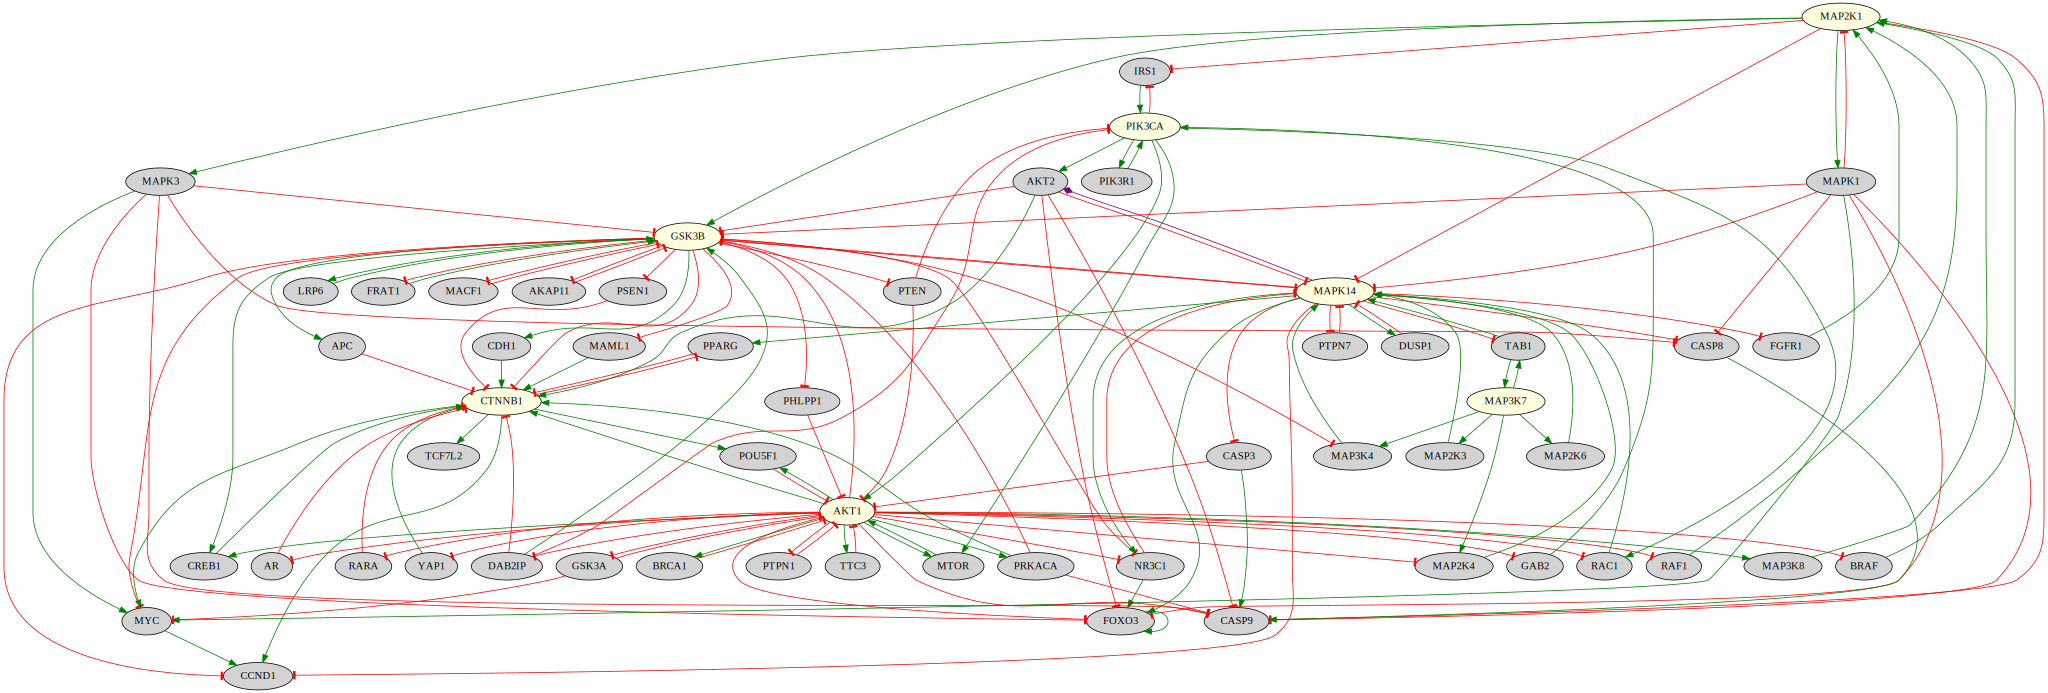

In [13]:
visualizer = NetworkVisualizer(new_net, color_by='effect', noi=True)
visualizer.render()

### 2D. Connect disconnected nodes by importing intermediate nodes.

The parameter _*maxlen*_ sets the maximum length of the paths to be searched of. 

The parameter _*algorithm*_ sets the base algorithm to use when looking for paths in the resources. It can be 'bfs' (Breadth-First Search) or 'dfs' (Depth-First Search). The first one is faster but does not always retrieve the shortest path, while the second one retrieves all the possible shortest paths at higher computational cost.

The parameter _*only_signed*_ forces the algorithm to look for just signed interactions. 

The parameter _*consensus*_ retrieves those interactions with a sign consensus between the references (when possible). 

The parameter _*connect_with_bias*_, changes the base algorithm, making it look for possible connection between all the disconnected node in the network when a new bridge-gene is introduced in the network, biasing the final network topology.

In [28]:
#%%time
#new_net.complete_connection(maxlen=3, algorithm="bfs", only_signed=True, connect_with_bias=False, consensus=True)

CPU times: user 812 ms, sys: 0 ns, total: 812 ms
Wall time: 811 ms


## 3. Visualize final network

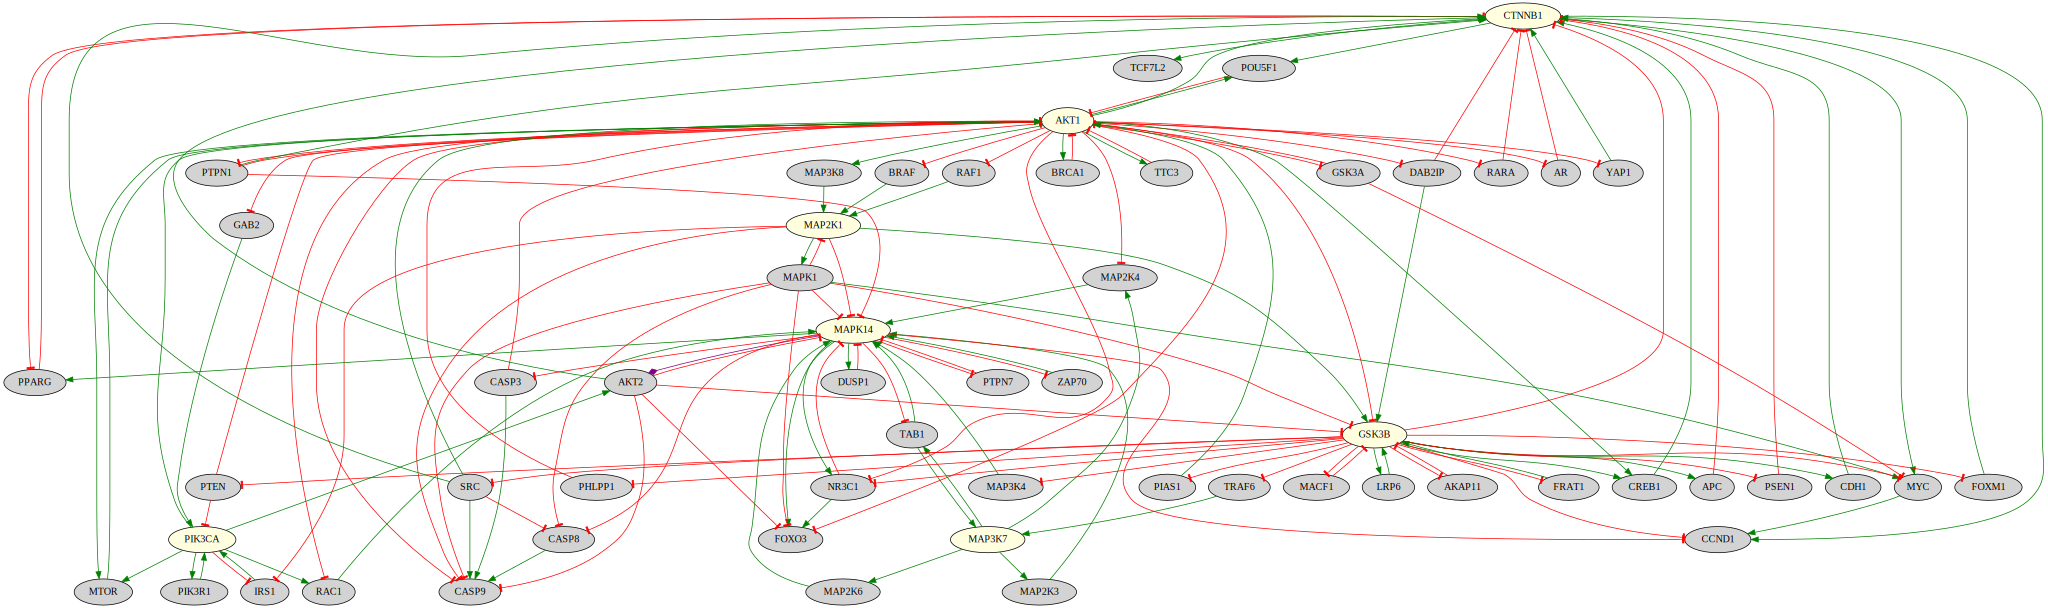

In [10]:
#Visualize a specific nodes and 
visualizer1 = NetworkVisualizer(new_net,color_by='effect', noi=True)
visualizer1.render()

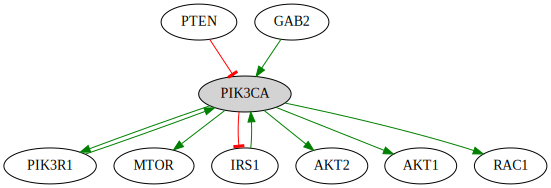

In [11]:
#Visualize a specific nodes and 
visualizer1 = NetworkVisualizer(new_net, predefined_node = "PIK3CA",color_by='effect')
visualizer1.render()

In [12]:
#We can access to the edges of the network
new_net.edges

,source,target,Type,Effect,References
0,P35222,Q01860,None,stimulation,21295277
1,P35222,P37231,None,inhibition,10937998
2,O43318,Q15750,None,stimulation,22216226
3,O43318,P52564,None,stimulation,11460167; 21902831
4,O43318,P45985,None,stimulation,9278437
...,...,...,...,...,...
235,P35222,P24385,None,stimulation,15735151; 12589056
236,P35222,Q9NQB0,None,stimulation,20492721
237,P35222,P01106,None,stimulation,16510874
246,P12931,P55211,None,stimulation,29844931


In [14]:
new_net.nodes

,Genesymbol,Uniprot,Type
0,MAP2K1,Q02750,NaN
1,PIK3CA,P42336,NaN
2,CTNNB1,P35222,NaN
3,MAP3K7,O43318,NaN
4,MAPK14,Q16539,NaN
5,GSK3B,P49841,NaN
6,AKT1,P31749,NaN
7,POU5F1,Q01860,NaN
8,PPARG,P37231,NaN
9,TAB1,Q15750,NaN


In [15]:
from neko._outputs.exports import Exports
export = Exports(new_net)
export.export_sif()